In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower


 ## HYPOTHESIS TEST 2

- $H_0$ : THERE IS NO DIFFERENCE IN WIN RATE BETWEEN 442 and 433

 
- $H_A$ : THERE IS A STAT DIFF IN WIN RATE 

##### Assumptions:
- Data is collected randomly
- Data is independent
- Data is approximately normally distributed

In [2]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Match
;'''

cur.execute(query)

match_data = cur.fetchall()
match_df = pd.DataFrame(match_data)
match_df.columns = [i[0] for i in cur.description]
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,sja,vch,vcd,vca,gbh,gbd,gba,bsh,bsd,bsa
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4,1.65,3.4,4.5,1.78,3.25,4,1.73,3.4,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.5,3.2,2.5,2.3,3.2,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.5,1.45,3.75,6.5,1.5,3.75,5.5,1.44,3.75,6.5
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.5,3.4,1.65,4.5,3.5,1.65,4.75,3.3,1.67


In [3]:
conn = psycopg2.connect('dbname=soccer')
cur = conn.cursor()

query = '''
SELECT *
FROM Team
;'''

cur.execute(query)

team_data = cur.fetchall()
team_df = pd.DataFrame(team_data)
team_df.columns = [i[0] for i in cur.description]
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [4]:
#create new column home_team_win with binary values - Home team winning = 1, Away team winning = 0
match_df['home_team_win'] = np.zeros

match_df['home_team_win'].loc[match_df['home_team_goal'] > match_df['away_team_goal']] = 1
match_df['home_team_win'].loc[match_df['home_team_goal'] < match_df['away_team_goal']] = 0
match_df['home_team_win'].loc[match_df['home_team_goal'] == match_df['away_team_goal']] = 0

match_df['away_team_win'] = np.zeros

match_df['away_team_win'].loc[match_df['home_team_goal'] < match_df['away_team_goal']] = 1
match_df['away_team_win'].loc[match_df['home_team_goal'] > match_df['away_team_goal']] = 0
match_df['away_team_win'].loc[match_df['home_team_goal'] == match_df['away_team_goal']] = 0

/Users/krex/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,vcd,vca,gbh,gbd,gba,bsh,bsd,bsa,home_team_win,away_team_win
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.4,4.5,1.78,3.25,4,1.73,3.4,4.2,0,0
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.5,3.2,2.5,2.3,3.2,2.75,0,1
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.5,1.5,3.75,5.5,1.44,3.75,6.5,1,0
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.4,1.65,4.5,3.5,1.65,4.75,3.3,1.67,0,1


In [6]:
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,vcd,vca,gbh,gbd,gba,bsh,bsd,bsa,home_team_win,away_team_win
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.4,4.5,1.78,3.25,4,1.73,3.4,4.2,0,0
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.5,3.2,2.5,2.3,3.2,2.75,0,1
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.5,1.5,3.75,5.5,1.44,3.75,6.5,1,0
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.4,1.65,4.5,3.5,1.65,4.75,3.3,1.67,0,1


In [7]:
result = pd.merge(match_df,
                  team_df[['team_long_name','team_api_id']],
                  left_on='home_team_api_id',
                  right_on='team_api_id',
                  how='left')
result.rename(columns={"team_long_name": "home_team_name"}, inplace=True)

result = result.drop(columns='team_api_id')

results = pd.merge(result,
                  team_df[['team_long_name','team_api_id']],
                  left_on='away_team_api_id',
                  right_on='team_api_id',
                  how='left')

results.rename(columns={"team_long_name": "away_team_name"}, inplace=True)

results = results.drop(columns='team_api_id')

In [8]:
results['winning_team'] = np.nan
results.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,gbd,gba,bsh,bsd,bsa,home_team_win,away_team_win,home_team_name,away_team_name,winning_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.25,4,1.73,3.4,4.2,0,0,KRC Genk,Beerschot AC,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.75,1.91,3.25,3.6,0,0,SV Zulte-Waregem,Sporting Lokeren,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.2,2.5,2.3,3.2,2.75,0,1,KSV Cercle Brugge,RSC Anderlecht,NaN
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,5.5,1.44,3.75,6.5,1,0,KAA Gent,RAEC Mons,NaN
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.5,1.65,4.75,3.3,1.67,0,1,FCV Dender EH,Standard de Liège,NaN


In [9]:
results['winning_team'].loc[results['home_team_goal'] > results['away_team_goal']] = results['home_team_name']
results['winning_team'].loc[results['home_team_goal'] < results['away_team_goal']] = results['away_team_name']




In [10]:
results.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,gbd,gba,bsh,bsd,bsa,home_team_win,away_team_win,home_team_name,away_team_name,winning_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.25,4,1.73,3.4,4.2,0,0,KRC Genk,Beerschot AC,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.75,1.91,3.25,3.6,0,0,SV Zulte-Waregem,Sporting Lokeren,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.2,2.5,2.3,3.2,2.75,0,1,KSV Cercle Brugge,RSC Anderlecht,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,5.5,1.44,3.75,6.5,1,0,KAA Gent,RAEC Mons,KAA Gent
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.5,1.65,4.75,3.3,1.67,0,1,FCV Dender EH,Standard de Liège,Standard de Liège


In [11]:
home_team_win_df = results.groupby("home_team_name").agg({
        "home_team_win": "mean",
    })

home_team_win_df.sort_values(by= 'home_team_win',ascending=False)

,home_team_win
home_team_name,
FC Barcelona,0.861842
Real Madrid CF,0.848684
SL Benfica,0.822581
FC Porto,0.822581
FC Bayern Munich,0.801471
Celtic,0.789474
PSV,0.772059
Manchester United,0.763158
Ajax,0.757353


In [12]:
away_team_win_df = results.groupby("away_team_name").agg({
        "away_team_win": "mean",
    })

away_team_win_df.sort_values(by= 'away_team_win',ascending=False)

,away_team_win
away_team_name,
Rangers,0.684211
FC Barcelona,0.677632
SL Benfica,0.669355
FC Porto,0.653226
Real Madrid CF,0.651316
Celtic,0.644737
FC Bayern Munich,0.617647
Ajax,0.573529
Juventus,0.560000


(0, 1)

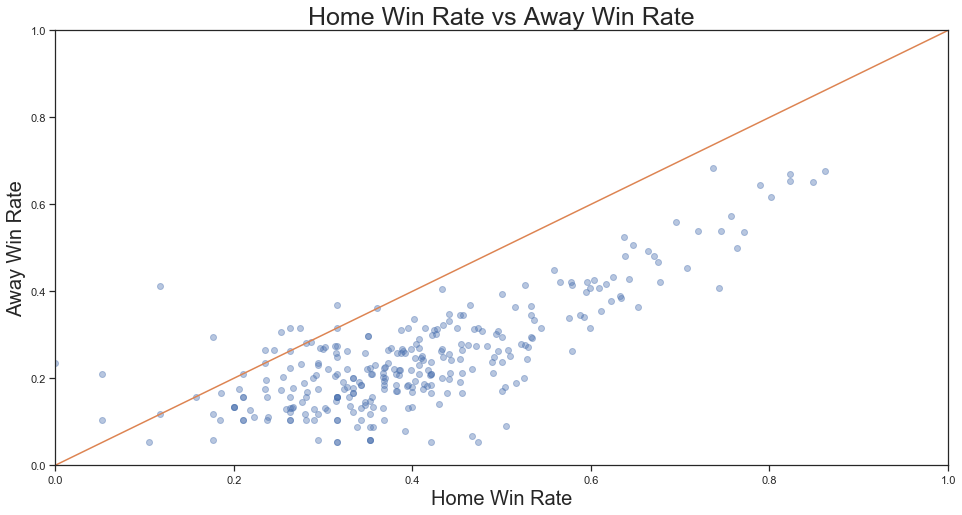

In [168]:
plt.figure(figsize=(16,8)) 
plt.plot(home_team_win_df,away_team_win_df,'o', alpha = 0.4)
plt.plot([0,1],[0,1])
plt.xlabel('Home Win Rate',fontsize='20')
plt.ylabel('Away Win Rate',fontsize='20')
plt.title('Home Win Rate vs Away Win Rate',fontsize='25')
plt.xlim([0,1])
plt.ylim([0,1])

In [14]:
results.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'gbd', 'gba', 'bsh', 'bsd', 'bsa', 'home_team_win', 'away_team_win',
       'home_team_name', 'away_team_name', 'winning_team'],
      dtype='object', length=120)

In [15]:
#loads info in the match_df, below is code to grab the columns of interest

h2_df = results[['match_api_id','home_team_goal','away_team_goal','home_player_y1','home_player_y2',
                        'home_player_y3','home_player_y4','home_player_y5','home_player_y6','home_player_y7',
                        'home_player_y8','home_player_y9','home_player_y10','home_player_y11','away_player_y1',
                        'away_player_y2','away_player_y3','away_player_y4','away_player_y5','away_player_y6',
                        'away_player_y7','away_player_y8','away_player_y9','away_player_y10','away_player_y11',
                        'winning_team', 'home_team_name', 'away_team_name']].copy()

h2_df

,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y5,away_player_y6,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,winning_team,home_team_name,away_team_name
0,492473,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KRC Genk,Beerschot AC
1,492474,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV Zulte-Waregem,Sporting Lokeren
2,492475,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RSC Anderlecht,KSV Cercle Brugge,RSC Anderlecht
3,492476,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KAA Gent,KAA Gent,RAEC Mons
4,492477,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard de Liège,FCV Dender EH,Standard de Liège
5,492478,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KV Mechelen,Club Brugge KV
6,492479,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KSV Roeselare,KV Kortrijk
7,492480,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Royal Excel Mouscron,Tubize,Royal Excel Mouscron
8,492481,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KVC Westerlo,KVC Westerlo,Sporting Charleroi
9,492564,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Club Brugge KV,Club Brugge KV,KV Kortrijk


In [16]:
from collections import Counter

In [17]:
def OnlyNum(s,oth=''):   
    nums = '0123456789'   
    for c in s:   
        if (c in nums) == False:   
             s = s.replace(c,'');   
    return s
#change the format of formation form str, this is for parse formation, only numbers show

In [18]:
home_formation = {}
away_formation = {}
#create two dict to store home team formation and away team formation, key is match_api_id, value is formation like '442'

In [19]:
#every row is a match, take out formation according to Y coordinates
for index,row in h2_df.iterrows():
    home_player_y = list()
    away_player_y = list()
    #create two list to store Y coordinate for each team,and they should be empty when we start parse a new match
    
    for i in range(2,12):
        home_player_y.append(row['home_player_y%d' % i])
        away_player_y.append(row['away_player_y%d' % i])
    #put two teams's Y coordinates into list    
    
    c_home = Counter(home_player_y)
    c_away = Counter(away_player_y)
    #transform list to Counter objects
    formation_home = Counter(sorted(c_home.elements())).values()
    #sorted,for exsample: Y coordinate may be record wrong, like "5,5,3,3,3,3,5,7,7,10",
    #the correct formation should be 4321,
    #but if we don't serted it, we will get 3421
    formation_home = OnlyNum(str(formation_home))
    #get only number, like '442', but it is still a string.
    formation_away = Counter(sorted(c_away.elements())).values()
    formation_away = OnlyNum(str(formation_away))
    
    home_formation.update({row['match_api_id'] : formation_home})
    away_formation.update({row['match_api_id'] : formation_away})
    #update match id and formation to dict

In [20]:
h2_df['home_formation'] = h2_df['match_api_id'].map(home_formation)
h2_df['away_formation'] = h2_df['match_api_id'].map(away_formation)
#map formation to DataFrame following match_api_id

In [21]:
h2_df.shape

(25979, 30)

In [22]:
h2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 30 columns):
match_api_id       25979 non-null int64
home_team_goal     25979 non-null int64
away_team_goal     25979 non-null int64
home_player_y1     24158 non-null float64
home_player_y2     24158 non-null float64
home_player_y3     24147 non-null float64
home_player_y4     24147 non-null float64
home_player_y5     24147 non-null float64
home_player_y6     24147 non-null float64
home_player_y7     24147 non-null float64
home_player_y8     24147 non-null float64
home_player_y9     24147 non-null float64
home_player_y10    24147 non-null float64
home_player_y11    24147 non-null float64
away_player_y1     24147 non-null float64
away_player_y2     24147 non-null float64
away_player_y3     24147 non-null float64
away_player_y4     24147 non-null float64
away_player_y5     24147 non-null float64
away_player_y6     24147 non-null float64
away_player_y7     24147 non-null float64
away_player_y8 

# The number of matches differs from the 
# I need to drop the na rows, since some games don't have formation data

- However to maintain tie games, I will use dropna(subset to target just where formations are not listed 

In [23]:
h2_dff = h2_df.dropna(subset=['home_player_y1', 'home_player_y2','away_player_y11','away_player_y10'])

h2_dff['winning_team'] = h2_dff['winning_team'].replace(np.nan, 'tie', regex=True)

h2_dff

/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,winning_team,home_team_name,away_team_name,home_formation,away_formation
144,493016,1,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,tie,Royal Excel Mouscron,RSC Anderlecht,442,442
145,493017,2,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,KV Mechelen,KV Mechelen,KRC Genk,442,442
146,493018,3,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Sporting Charleroi,Sporting Charleroi,RAEC Mons,442,442
147,493019,4,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Standard de Liège,Standard de Liège,KSV Cercle Brugge,442,442
148,493020,0,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,KAA Gent,Sporting Lokeren,KAA Gent,442,442
149,493021,2,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Club Brugge KV,Club Brugge KV,KSV Roeselare,442,442
150,493022,3,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Beerschot AC,Beerschot AC,KV Kortrijk,442,442
152,493023,4,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,FCV Dender EH,FCV Dender EH,Tubize,442,442
153,493024,1,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,tie,SV Zulte-Waregem,KVC Westerlo,442,442
154,493025,1,3,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Club Brugge KV,KSV Cercle Brugge,Club Brugge KV,442,442


In [24]:
print(h2_dff.home_formation.unique())
print(h2_dff.away_formation.unique())

['442' '451' '343' '433' '532' '352' '541' '3331' '4141' '3232' '4231'
 '3511' '4321' '4411' '3412' '41212' '4213' '4312' '4132' '5311' '4123'
 '3421' '4222' '41221']
['442' '343' '433' '532' '451' '3331' '541' '352' '4213' '4231' '4411'
 '4141' '4321' '3412' '41212' '4222' '4123' '4312' '4132' '3511' '3421'
 '5311' '31312' '41221' '3232']


In [25]:
set(h2_dff.home_formation.unique())-set(h2_dff.away_formation.unique())
#compare home team and away team formation , the number of home formation is no more than away formation
# no difference, yay!

set()

In [26]:
set(h2_dff.away_formation.unique())-set(h2_dff.home_formation.unique())
#but away formation has one special item formation '31312', lets check it out!

{'31312'}

In [27]:
h2_dff[h2_dff['away_formation']=='31312']
#that is only one match with equalize 0:0, so I drop it.

,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,winning_team,home_team_name,away_team_name,home_formation,away_formation
4576,1724003,0,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,9.0,11.0,11.0,tie,Burnley,Manchester United,442,31312


In [28]:
index31312 = h2_dff[h2_dff['away_formation']=='31312'].index.get_values().copy()
h2_dff.drop(index31312,inplace=True)

/Users/krex/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
h2_dff[h2_dff['away_formation']=='31312']

,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,winning_team,home_team_name,away_team_name,home_formation,away_formation


now its gone!

In [30]:
h2_dff.head()

,match_api_id,home_team_goal,away_team_goal,home_player_y1,home_player_y2,home_player_y3,home_player_y4,home_player_y5,home_player_y6,home_player_y7,...,away_player_y7,away_player_y8,away_player_y9,away_player_y10,away_player_y11,winning_team,home_team_name,away_team_name,home_formation,away_formation
144,493016,1,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,tie,Royal Excel Mouscron,RSC Anderlecht,442,442
145,493017,2,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,KV Mechelen,KV Mechelen,KRC Genk,442,442
146,493018,3,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Sporting Charleroi,Sporting Charleroi,RAEC Mons,442,442
147,493019,4,0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,Standard de Liège,Standard de Liège,KSV Cercle Brugge,442,442
148,493020,0,1,1.0,3.0,3.0,3.0,3.0,7.0,7.0,...,7.0,7.0,7.0,10.0,10.0,KAA Gent,Sporting Lokeren,KAA Gent,442,442


In [31]:
# delete Y coordinate, because we'dont need them anymore.
h2_dff.drop(columns=['home_player_y1','home_player_y2','home_player_y3','home_player_y4','home_player_y5','home_player_y6','home_player_y7','home_player_y8','home_player_y9','home_player_y10','home_player_y11'],inplace = True)
h2_dff.drop(columns=['away_player_y1','away_player_y2','away_player_y3','away_player_y4','away_player_y5','away_player_y6','away_player_y7','away_player_y8','away_player_y9','away_player_y10','away_player_y11'],inplace = True)


In [32]:
h2_dff['away_formation'].value_counts()

4231     6454
442      6078
433      4354
451      1224
4411      846
4141      708
352       696
4312      613
4222      547
41212     513
41221     366
343       283
4321      264
4132      238
532       193
3421      184
3511      147
541       137
3412      136
4123       93
4213       34
3232       16
3331       13
5311        2
Name: away_formation, dtype: int64

In [33]:
h2_dff['home_formation'].value_counts()

4231     6429
442      6422
433      4374
451       943
4411      879
352       685
4312      681
4141      632
41212     565
4222      552
41221     373
343       283
4132      253
4321      240
532       187
3421      166
3412      145
3511      123
4123       79
541        70
4213       35
3232       13
3331        8
5311        2
Name: home_formation, dtype: int64

## TOP FORMATIONS

#### home : 
-4231     6429

-442      6422

-433      4374

#### away: 
-4231     6454

-442      6078

-433      4354

In [34]:
#create new column home_team_win with binary values - Home team winning = 1, Tie=0 , Away team winning = 0
h2_dff['winning_formation'] = np.nan

/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
h2_dff['winning_formation'] #success

144     NaN
145     NaN
146     NaN
147     NaN
148     NaN
149     NaN
150     NaN
152     NaN
153     NaN
154     NaN
155     NaN
156     NaN
157     NaN
158     NaN
159     NaN
160     NaN
162     NaN
163     NaN
164     NaN
165     NaN
166     NaN
167     NaN
168     NaN
169     NaN
170     NaN
172     NaN
173     NaN
174     NaN
175     NaN
176     NaN
         ..
25949   NaN
25950   NaN
25951   NaN
25952   NaN
25953   NaN
25954   NaN
25955   NaN
25956   NaN
25957   NaN
25958   NaN
25959   NaN
25960   NaN
25961   NaN
25962   NaN
25963   NaN
25964   NaN
25965   NaN
25966   NaN
25967   NaN
25968   NaN
25969   NaN
25970   NaN
25971   NaN
25972   NaN
25973   NaN
25974   NaN
25975   NaN
25976   NaN
25977   NaN
25978   NaN
Name: winning_formation, Length: 24139, dtype: float64

In [36]:
h2_dff['winning_formation'].loc[h2_dff['home_team_goal'] > h2_dff['away_team_goal']] = h2_dff['home_formation']
h2_dff['winning_formation'].loc[h2_dff['home_team_goal'] < h2_dff['away_team_goal']] = h2_dff['away_formation']








/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
h2_dff.head(10)

,match_api_id,home_team_goal,away_team_goal,winning_team,home_team_name,away_team_name,home_formation,away_formation,winning_formation
144,493016,1,1,tie,Royal Excel Mouscron,RSC Anderlecht,442,442,NaN
145,493017,2,1,KV Mechelen,KV Mechelen,KRC Genk,442,442,442
146,493018,3,0,Sporting Charleroi,Sporting Charleroi,RAEC Mons,442,442,442
147,493019,4,0,Standard de Liège,Standard de Liège,KSV Cercle Brugge,442,442,442
148,493020,0,1,KAA Gent,Sporting Lokeren,KAA Gent,442,442,442
149,493021,2,1,Club Brugge KV,Club Brugge KV,KSV Roeselare,442,442,442
150,493022,3,0,Beerschot AC,Beerschot AC,KV Kortrijk,442,442,442
152,493023,4,0,FCV Dender EH,FCV Dender EH,Tubize,442,442,442
153,493024,1,1,tie,SV Zulte-Waregem,KVC Westerlo,442,442,NaN
154,493025,1,3,Club Brugge KV,KSV Cercle Brugge,Club Brugge KV,442,442,442


# Want to know how many times home 442 wins / home 442 was played

In [38]:
h2_dff['442_win'] = pd.Series(np.nan)
h2_dff['442_win'].loc[h2_dff['winning_formation'] == '442'] = 1
h2_dff['442_win'].loc[h2_dff['winning_formation'] != '442'] = 0

h2_dff['442_featured'] = pd.Series(np.nan)
h2_dff['442_featured'].loc[(h2_dff['home_formation'] == '442' )|(h2_dff['away_formation'] == '442')] = 1
h2_dff['442_featured'].loc[(h2_dff['home_formation'] != '442' ) & (h2_dff['away_formation'] != '442')] = 0




h2_dff['433_win'] = pd.Series(np.nan)
h2_dff['433_win'].loc[h2_dff['winning_formation'] == '433'] = 1
h2_dff['433_win'].loc[h2_dff['winning_formation'] != '433'] = 0

h2_dff['433_featured'] = pd.Series(np.nan)
h2_dff['433_featured'].loc[(h2_dff['home_formation'] == '433' )|(h2_dff['away_formation'] == '433')] = 1
h2_dff['433_featured'].loc[(h2_dff['home_formation'] != '433' ) & (h2_dff['away_formation'] != '433')] = 0


/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/krex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from

In [39]:
h2_dff

,match_api_id,home_team_goal,away_team_goal,winning_team,home_team_name,away_team_name,home_formation,away_formation,winning_formation,442_win,442_featured,433_win,433_featured
144,493016,1,1,tie,Royal Excel Mouscron,RSC Anderlecht,442,442,NaN,0.0,1.0,0.0,0.0
145,493017,2,1,KV Mechelen,KV Mechelen,KRC Genk,442,442,442,1.0,1.0,0.0,0.0
146,493018,3,0,Sporting Charleroi,Sporting Charleroi,RAEC Mons,442,442,442,1.0,1.0,0.0,0.0
147,493019,4,0,Standard de Liège,Standard de Liège,KSV Cercle Brugge,442,442,442,1.0,1.0,0.0,0.0
148,493020,0,1,KAA Gent,Sporting Lokeren,KAA Gent,442,442,442,1.0,1.0,0.0,0.0
149,493021,2,1,Club Brugge KV,Club Brugge KV,KSV Roeselare,442,442,442,1.0,1.0,0.0,0.0
150,493022,3,0,Beerschot AC,Beerschot AC,KV Kortrijk,442,442,442,1.0,1.0,0.0,0.0
152,493023,4,0,FCV Dender EH,FCV Dender EH,Tubize,442,442,442,1.0,1.0,0.0,0.0
153,493024,1,1,tie,SV Zulte-Waregem,KVC Westerlo,442,442,NaN,0.0,1.0,0.0,0.0
154,493025,1,3,Club Brugge KV,KSV Cercle Brugge,Club Brugge KV,442,442,442,1.0,1.0,0.0,0.0


In [40]:
total_442_feat = h2_dff['442_featured'].sum()
total_442_feat #n of 442

total_433_feat = h2_dff['433_featured'].sum()
total_433_feat #n of 433

total_442_wins = h2_dff['442_win'].sum()
total_442_wins 

win_ratio_442 = total_442_wins/total_442_feat
win_ratio_442

total_433_wins = h2_dff['433_win'].sum() 

win_ratio_433 = total_433_wins/total_433_feat
win_ratio_433

four42_win_array = np.array(h2_dff['442_win'])

four33_win_array = np.array(h2_dff['433_win'])

In [41]:
total_442_feat

9034.0

In [42]:
std_442 = np.std(h2_dff['442_win'])
std_433= np.std(h2_dff['433_win'])

cohens_d = (win_ratio_442 - win_ratio_433) / (np.sqrt((std_442 ** 2 + std_433 ** 2) / 2))
cohens_d

0.05104004593362786

In [132]:
# Initialize parameters
effect = cohens_d
alpha = 0.05
power = 0.80
# sample 2 / sample 1     which is 433win sum /442 wins  sum
ratio = sum(h2_dff['433_featured']) / sum(h2_dff['442_featured'])
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"Number of matches where 442 formation is played:{sum(h2_dff['442_featured'])}")

The minimum sample size: 7023.795797934475
Number of matches where 442 formation is played:9034.0


In [131]:
# Initialize parameters
effect = cohens_d
alpha = 0.05
power = 0.80
# sample 2 / sample 1     which is 433win sum /442 wins  sum
ratio = sum(h2_dff['442_featured']) / sum(h2_dff['433_featured'])
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"Number of matches where 433 formation is played:{sum(h2_dff['433_featured'])}")

The minimum sample size: 5277.565405843527
Number of matches where 433 formation is played:6788.0


In [133]:
sample_win_rates_442 = []
for _ in range(10**4):
    sample = h2_dff.sample(7050)
    sample_win_rate = sum(sample['442_win'])/sum(sample['442_featured'])
    sample_win_rates_442.append(sample_win_rate)
len(sample_win_rates_442)

sample_win_rates_433 = []
for _ in range(10**4):
    sample = h2_dff.sample(7050)
    sample_win_rate = sum(sample['433_win'])/sum(sample['433_featured'])
    sample_win_rates_433.append(sample_win_rate)
len(sample_win_rates_433)

10000

In [124]:
def calc_variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def calc_sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var1, var2 = calc_variance(sample1), calc_variance(sample2)
    return (var1 + var2) / ((n_1 + n_2) - 2)

def calc_twosample_tstatistic(expr, ctrl):
    expr_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    n_e, n_c = len(expr), len(ctrl)
    samp_var = calc_sample_variance(expr,ctrl)
    t = (expr_mean - ctrl_mean) / np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return t

In [134]:
t_stat = calc_twosample_tstatistic(sample_win_rates_442, sample_win_rates_433)

t_stat

152.46377732030416

In [135]:
stats.ttest_ind(sample_win_rates_442, sample_win_rates_433)

Ttest_indResult(statistic=152.46377732030425, pvalue=0.0)

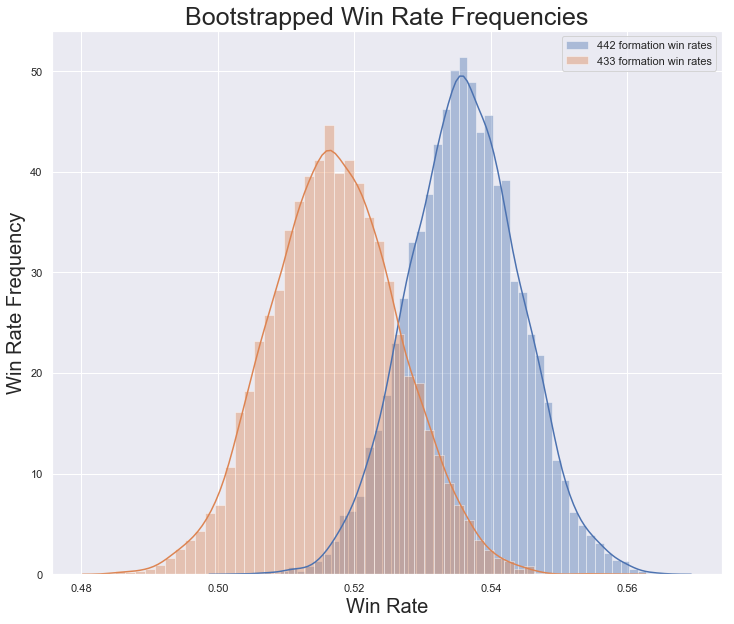

In [136]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
plt.title('Bootstrapped Win Rate Frequencies', fontsize='25')
plt.xlabel('Win Rate', fontsize='20')
plt.ylabel('Win Rate Frequency', fontsize='20')
sns.distplot(sample_win_rates_442,label='442 formation win rates') # Blue distribution
sns.distplot(sample_win_rates_433,label='433 formation win rates') # Orange distribution
plt.legend()
plt.show();

## Conclusion:
- With our bootstrapping method, taking many many samples normalizes our two sample distributions, and our p value is exactly 0.00, smaller than our alpha of 0.05.
- Thus, we can reject our $H_0$ in favor of our $H_A$ hypothesis. There seems to be a statistically signficant difference in win rates between the 442 and the 433 formations.

In [137]:
four42_df = h2_dff.loc[h2_dff['442_featured'] == 1]

In [138]:
four42_df.head()

,match_api_id,home_team_goal,away_team_goal,winning_team,home_team_name,away_team_name,home_formation,away_formation,winning_formation,442_win,442_featured,433_win,433_featured
144,493016,1,1,tie,Royal Excel Mouscron,RSC Anderlecht,442,442,NaN,0.0,1.0,0.0,0.0
145,493017,2,1,KV Mechelen,KV Mechelen,KRC Genk,442,442,442,1.0,1.0,0.0,0.0
146,493018,3,0,Sporting Charleroi,Sporting Charleroi,RAEC Mons,442,442,442,1.0,1.0,0.0,0.0
147,493019,4,0,Standard de Liège,Standard de Liège,KSV Cercle Brugge,442,442,442,1.0,1.0,0.0,0.0
148,493020,0,1,KAA Gent,Sporting Lokeren,KAA Gent,442,442,442,1.0,1.0,0.0,0.0


In [139]:
four33_df = h2_dff.loc[h2_dff['433_featured'] == 1]

In [140]:
four33_df.head()

,match_api_id,home_team_goal,away_team_goal,winning_team,home_team_name,away_team_name,home_formation,away_formation,winning_formation,442_win,442_featured,433_win,433_featured
518,838469,2,0,KV Mechelen,KV Mechelen,Sporting Lokeren,433,343,433,0.0,0.0,1.0,1.0
519,838472,0,1,KAA Gent,KVC Westerlo,KAA Gent,532,433,433,0.0,0.0,1.0,1.0
530,838587,2,2,tie,KV Mechelen,KRC Genk,433,532,NaN,0.0,0.0,0.0,1.0
533,838591,4,2,KRC Genk,KRC Genk,Standard de Liège,343,433,343,0.0,0.0,0.0,1.0
535,838594,2,3,Club Brugge KV,SV Zulte-Waregem,Club Brugge KV,433,451,451,0.0,0.0,0.0,1.0


In [141]:
four42_win_array = np.array(four42_df['442_win'])

four33_win_array = np.array(four33_df['433_win'])

In [142]:
len(four42_df), len(four33_df)

(9034, 6788)

In [143]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [144]:
ratio_442 = sum(four42_df['442_win'])/len(four42_df)
ratio_433 = sum(four33_df['433_win'])/len(four33_df)
var442 = four42_df['442_win'].var()
var433 = four33_df['433_win'].var()

pooled_var = (len(four42_df) * var442 + len(four33_df) * var433) / (len(four42_df) + len(four33_df))
diff = ratio_442 - ratio_433
#std_442 = np.std(four42_df['442_win'])
#std_433= np.std(four33_df['433_win'])
d = diff / np.sqrt(pooled_var)
d

0.038574696472695784

In [145]:
# Initialize parameters
effect = d
alpha = 0.05
power = 0.67
# ratio of 442wins which is 442win sum /442feat  sum
ratio = len(four33_df)/len(four42_df)
print(ratio)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"Number of matches where 442 formation is played:{len(four42_df)}")

0.7513836617223821
The minimum sample size: 9022.748117789175
Number of matches where 442 formation is played:9034


In [147]:
# Initialize parameters
effect = d
alpha = 0.05
power = 0.67
# ratio of 442wins which is 442win sum /442feat  sum
ratio = len(four42_df)/len(four33_df)
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"The minimum sample size: {result}")
print(f"Number of matches where 433 formation is played:{len(four33_df)}")

The minimum sample size: 6779.545519632082
Number of matches where 433 formation is played:6788


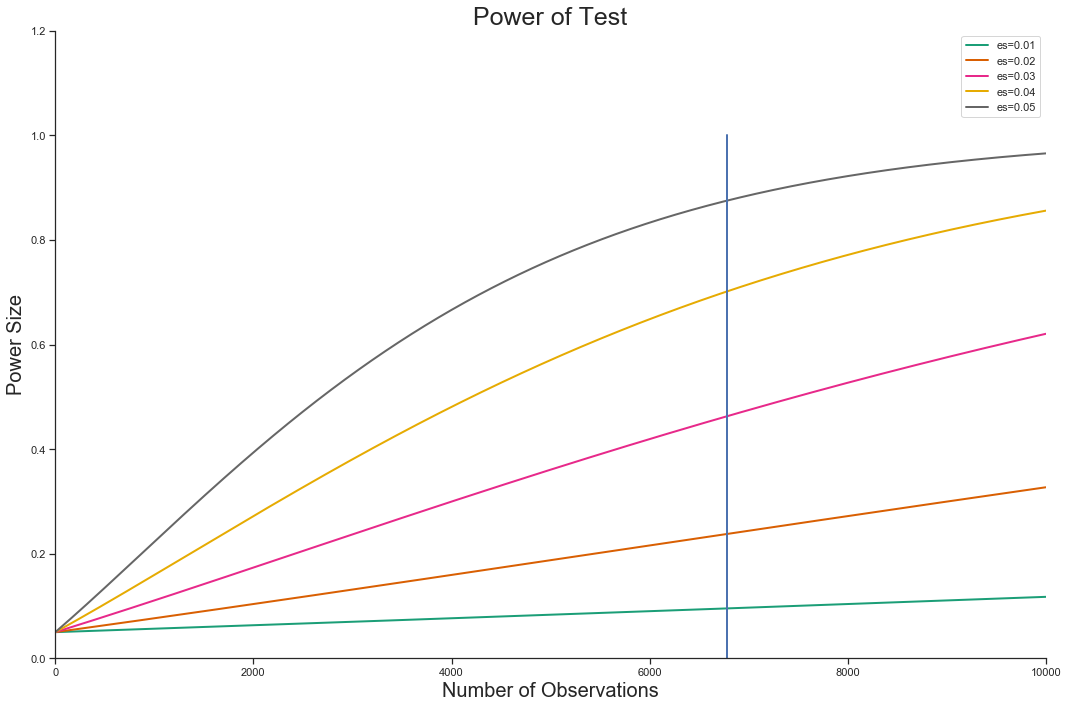

In [149]:
# parameters for power analysis
effect_sizes = np.array([0.01,0.02, 0.03,.04,.05])
sample_sizes = np.array(range(1,10000))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, alpha=alpha ,ratio=ratio, effect_size=effect_sizes, plt_kwds={'colors':'k'})
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 10000)
plt.ylim(0,1.2)
plt.plot([result, result],[0, 1], linewidth=2)
plt.ylabel('Power Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

In [111]:
sample_442_win_rates = []
for _ in range(10**4):
    sample_mean = np.random.choice(four42_win_array,size=9024).mean()
    sample_442_win_rates.append(sample_mean)
len(sample_442_win_rates)

sample_433_win_rates = []
for _ in range(10**4):
    sample_mean = np.random.choice(four33_win_array,size=6780).mean()
    sample_433_win_rates.append(sample_mean)
len(sample_433_win_rates)

10000

In [158]:
t_stat = calc_twosample_tstatistic(sample_442_win_rates, sample_433_win_rates)

t_stat

238.51145298196326

In [113]:
stats.ttest_ind(sample_442_win_rates, sample_433_win_rates)

Ttest_indResult(statistic=238.51145298196224, pvalue=0.0)

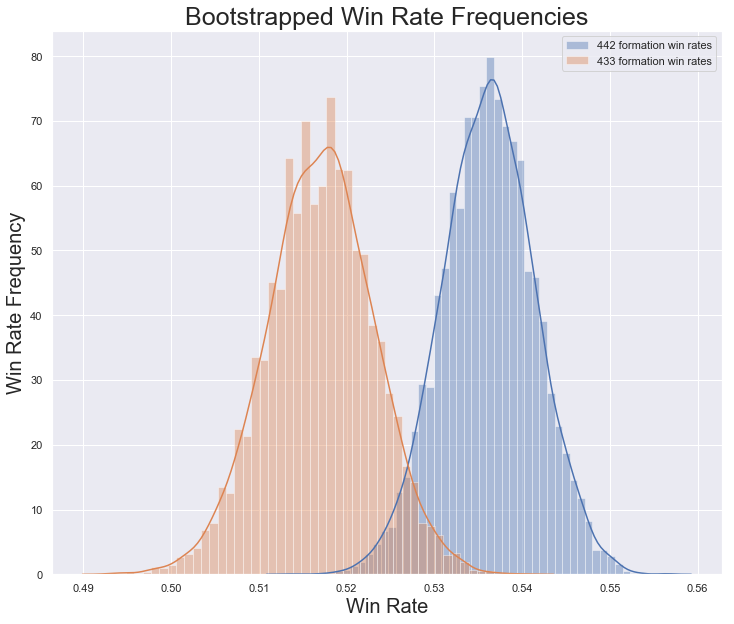

In [114]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
plt.title('Bootstrapped Win Rate Frequencies', fontsize='25')
plt.xlabel('Win Rate', fontsize='20')
plt.ylabel('Win Rate Frequency', fontsize='20')
sns.distplot(sample_442_win_rates,label='442 formation win rates') # Blue distribution
sns.distplot(sample_433_win_rates,label='433 formation win rates') # Orange distribution
plt.legend()
plt.show()

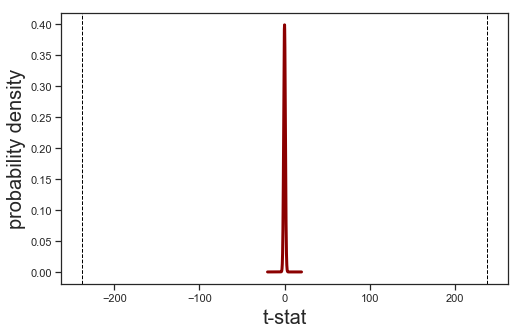

In [165]:
def visualize_t(t_stat, n_control, n_experimental):
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -20 and 20:
    xs = np.linspace(-20, 20, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat,color='black', linestyle='--', lw=1)
    ax.axvline(-t_stat,color='black', linestyle='--', lw=1)
    plt.xlabel('t-stat', fontsize='20')
    plt.ylabel('probability density', fontsize='20')
    
    plt.show()
    return None

n_442 = len(four42_win_array)
n_433 = len(four33_win_array)
visualize_t(t_stat, n_442, n_433)

In [150]:
stats.t.sf(abs(t_stat),  n_442+n_433-1) * 2

0.0

verifies our earlier p value earlier calculated